# **Import Libraries**

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# **Daten**

In [2]:
# Google Drive mounten
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Verzeichnis mit den Mapping-Dateien
mapping_snomed_icd = "/content/drive/MyDrive/Gruppe A/Mapping-CSV/map_snomed_icd.csv"
mapping_loinc_snomed = "/content/drive/MyDrive/Gruppe A/Mapping-CSV/map_loinc_snomed.csv"

# Verbindung zur Datenbank
database_file = "/content/drive/MyDrive/Gruppe A/COVID 19 DB/covid19_data.db"

try:
    # Versuche, eine Verbindung zur Datenbank herzustellen
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    print("Verbindung zur Datenbank wurde erfolgreich hergestellt.")
except sqlite3.Error as e:
    # Falls ein Fehler auftritt, wird dieser ausgegeben
    print(f"Fehler bei der Verbindung zur Datenbank: {e}")


Mounted at /content/drive
Verbindung zur Datenbank wurde erfolgreich hergestellt.


In [3]:
# Mapping-Tabelle von SNOMED nach ICD

map_icd = pd.read_csv(mapping_snomed_icd, sep = ";")
map_icd.head()

,snomed,snomed_desc,icd,icd_desc
0,22298006,Myocardial Infarction,I21.9,"Myocardial infarction, unspecified"
1,25064002,Headache (finding),R51,Headache
2,36955009,Loss of taste (finding),R43.1,Ageusia
3,40095003,Injury of kidney (disorder),S37.9,"Injury of kidney, unspecified"
4,43724002,Chill (finding),R68.83,Chills


In [4]:
# Mapping-Tabelle von LOINC zu SNOMED-CT
## erstellt von ChatGPT
map_loinc = pd.read_csv(mapping_loinc_snomed, sep = ";")
map_loinc.snomed= map_loinc.snomed.str.strip()
map_loinc.snomed = map_loinc.snomed.replace("NA", np.nan) # NAs korrekt kodieren
map_loinc.head()

,loinc,loinc_desc,snomed,snomed_desc
0,14804-9,Lactate dehydrogenase [Enzymatic activity/volu...,NaN,NaN
1,1742-6,Alanine aminotransferase [Enzymatic activity/v...,163515005,Alanine aminotransferase measurement
2,1751-7,Albumin [Mass/volume] in Serum or Plasma,104926008,Serum albumin measurement
3,17861-6,Calcium [Mass/volume] in Serum or Plasma,279000006,"Calcium measurement, serum"
4,1920-8,Aspartate aminotransferase [Enzymatic activity...,163513002,Aspartate aminotransferase measurement


# **Mapping SNOMED-CT auf ICD-10**

Tabelle conditions enthält Diagnosen in Form von SNOMED-CT-Codes. Mapping auf ICD-Klassifikation

In [5]:
# conditions table
query = """
SELECT *
FROM conditions
"""

conditions = pd.read_sql_query(query, conn)
conditions.columns = conditions.columns.str.lower()
conditions = conditions.rename(columns = {"code":"snomed", "description":"snomed_desc"})

conditions_mapped = conditions.merge(map_icd, how="left", on = ["snomed", "snomed_desc"])
conditions_mapped.head()


,start,stop,patient,encounter,snomed,snomed_desc,icd,icd_desc
0,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,49727002,Cough (finding),R05,Cough
1,2020-02-24,2020-03-11,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,ccb50c60-5c51-3d03-3aeb-824325cfac91,49727002,Cough (finding),R05,Cough
2,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,386661006,Fever (finding),R50.9,"Fever, unspecified"
3,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,36955009,Loss of taste (finding),R43.1,Ageusia
4,2020-02-17,2020-02-17,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,840544004,Suspected COVID-19,U07.2,"COVID-19, virus not identified"


In [6]:
print(f"Tabelle conditions:\nFür {conditions_mapped[['snomed', 'icd']].drop_duplicates().dropna(subset=['icd']).shape[0]} von {conditions_mapped['snomed'].nunique()} SNOMED-CT-Codes konnte ein passender ICD-Code gefunden werden")


Tabelle conditions:
Für 41 von 41 SNOMED-CT-Codes konnte ein passender ICD-Code gefunden werden


## **Visualisierung SNOMED-CT auf ICD-10**

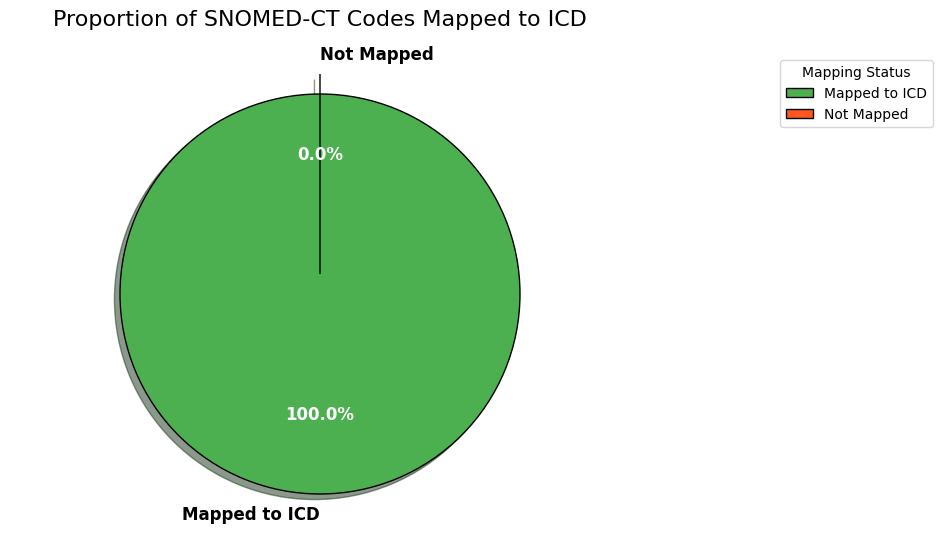

In [7]:
df_mapped = conditions_mapped[['snomed', 'snomed_desc', 'icd', 'icd_desc']].drop_duplicates()

# Annahme: df_mapped ist ein DataFrame mit einer Spalte 'icd'

# Berechnung der gemappten und nicht gemappten ICD-Codes
mapping_counts = df_mapped['icd'].notna().value_counts()
mapped_icd_count = mapping_counts.get(True, 0)  # Gemappte Codes
unmapped_icd_count = mapping_counts.get(False, 0)  # Nicht gemappte Codes

# Daten für die Visualisierung
labels = ['Mapped to ICD', 'Not Mapped']
sizes = [mapped_icd_count, unmapped_icd_count]
colors = ['#4CAF50', '#FF5722']  # Grün und Orange
explode = (0.1, 0)  # Hervorheben des ersten Segments (gemappte Codes)

# Erstellung des Kreisdiagramms
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    sizes, explode=explode, labels=labels, autopct='%1.1f%%',
    startangle=90, colors=colors, shadow=True, wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 12, 'color': 'black', 'weight': 'bold'}
)

# Anpassung der Prozentangaben
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')  # Bessere Lesbarkeit auf farbigen Segmenten

# Titel und Legende
plt.title('Proportion of SNOMED-CT Codes Mapped to ICD', fontsize=16, pad=20)
plt.legend(wedges, labels, title="Mapping Status", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

# Kreisdiagramm als Kreis darstellen
plt.axis('equal')

# Diagramm speichern
plt.savefig('snomed_icd_mapping_pie_chart.png', dpi=300, bbox_inches='tight')

# Diagramm anzeigen
plt.show()

In [8]:
# Stichprobenhafte Inspektion der Verknüpfungen
df_mapped

# Auszug  für PPT
beispiel = [49727002, 267036007, 389087006, 67782005, 68962001]
df_mapped[df_mapped["snomed"].isin(beispiel)]

,snomed,snomed_desc,icd,icd_desc
0,49727002,Cough (finding),R05,Cough
8,267036007,Dyspnea (finding),R06.0,Dyspnea
41,389087006,Hypoxemia (disorder),R09.02,Hypoxemia
75,68962001,Muscle pain (finding),M79.1,Myalgia
410,67782005,Acute respiratory distress syndrome (disorder),J80,Acute respiratory distress syndrome


# **Mapping LOINC auf SNOMED-CT**

In [9]:
query = """
SELECT *
FROM observations
"""

observations = pd.read_sql_query(query, conn)
observations.columns = observations.columns.str.lower()
observations = observations.rename(columns = {'code':'loinc', 'description':'loinc_desc'})
observations = observations.dropna(subset = ["loinc"]) # NAs entfernen

#gültige LOINC-Codes (format: nnnnn-n)
observations = observations[
    observations["loinc"].str.match(r"^\d{3,5}-\d$") |
    observations["loinc"].str.match(r"^\d{6}$")]

observations_mapped = observations.merge(map_loinc, how="left", on=["loinc", "loinc_desc"])
observations_mapped

,date,patient,encounter,loinc,loinc_desc,value,units,type,snomed,snomed_desc
0,2020-02-17T21:57:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,8310-5,Body temperature,41.4,Cel,numeric,56342008,Body temperature
1,2020-02-17T21:57:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,9279-1,Respiratory rate,21.4,/min,numeric,86290005,Respiratory rate
2,2020-02-17T21:57:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,8867-4,Heart rate,61.6,/min,numeric,364075005,Heart rate
3,2020-02-17T21:57:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,2708-6,Oxygen saturation in Arterial blood,77.4,%,numeric,103228002,Oxygen saturation measurement
4,2020-02-17T21:57:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,1d453a83-17f7-490d-5576-09f5725cdcaa,8462-4,Diastolic Blood Pressure,85.0,mm[Hg],numeric,271650006,Diastolic blood pressure
...,...,...,...,...,...,...,...,...,...,...
87511,2020-03-28T16:40:19Z,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,1988-5,C reactive protein [Mass/volume] in Serum or P...,15.6,mg/L,numeric,302635004,C reactive protein measurement
87512,2020-03-28T16:40:19Z,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,5902-2,Prothrombin time (PT),13.6,s,numeric,304789004,Prothrombin time measurement
87513,2020-03-28T16:40:19Z,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,6301-6,INR in Platelet poor plasma by Coagulation assay,3.1,{INR},numeric,333653003,International normalized ratio (INR)
87514,2020-03-28T16:40:19Z,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,33959-8,Procalcitonin [Mass/volume] in Serum or Plasma,0.3,ng/mL,numeric,NaN,NaN


In [10]:
# Anzeige, wieviele LOINC-Codes gemapped wurden
print(f"Tabelle observations:\nFür {observations_mapped[['loinc', 'snomed']].drop_duplicates().dropna(subset=['snomed']).shape[0]} von {observations_mapped['loinc'].nunique()} LOINC-Codes konnte ein passender SNOMED-CT-Code gefunden werden")

# Filtere die Zeilen, in denen kein SNOMED-CT-Code vorhanden ist
df_unmapped = observations_mapped[observations_mapped['snomed'].isna()]

# Zähle die eindeutigen Patienten-IDs in den nicht gemappten Zeilen
patient_unmapped_count = df_unmapped['patient'].nunique()

# Zähle die eindeutigen Patienten-IDs im gesamten DataFrame (alle Patienten)
total_patient_count = observations_mapped['patient'].nunique()

# Berechne das Verhältnis der nicht gemappten Patienten zur Gesamtzahl
ratio = patient_unmapped_count / total_patient_count

# Ausgabe des Verhältnisses als Prozentwert
print(f"Verhältnis der Patienten mit nicht gemapptem SNOMED-CT-Code zur Gesamtzahl: {ratio:.2%}")

# ------------------------------------------------------------------
# Zusätzliche Ausgabe: Liste der LOINC-Codes, die nicht gemapped wurden
# ------------------------------------------------------------------

# Erstelle eine Liste der einzigartigen LOINC-Codes aus den ungemappten Zeilen
unmapped_loinc_list = df_unmapped[['loinc', 'loinc_desc']].drop_duplicates().apply(tuple, axis=1).tolist()

print("\nListe der LOINC-Codes, für die kein SNOMED-CT-Code gefunden wurde:")
for loinc, desc in unmapped_loinc_list:
    print(f"LOINC: {loinc} ({desc})")


Tabelle observations:
Für 51 von 68 LOINC-Codes konnte ein passender SNOMED-CT-Code gefunden werden
Verhältnis der Patienten mit nicht gemapptem SNOMED-CT-Code zur Gesamtzahl: 38.71%

Liste der LOINC-Codes, für die kein SNOMED-CT-Code gefunden wurde:
LOINC: 92142-9 (Influenza virus A RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92141-1 (Influenza virus B RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92131-2 (Respiratory syncytial virus RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92140-3 (Parainfluenza virus 1 RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92139-5 (Parainfluenza virus 2 RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92138-7 (Parainfluenza virus 3 RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92130-4 (Rhinovirus RNA [Presence] in Respiratory specimen by NAA with probe detection)
LOINC: 92134-6 (Huma

## **Visualisierung LOINC auf SNOMED-CT**

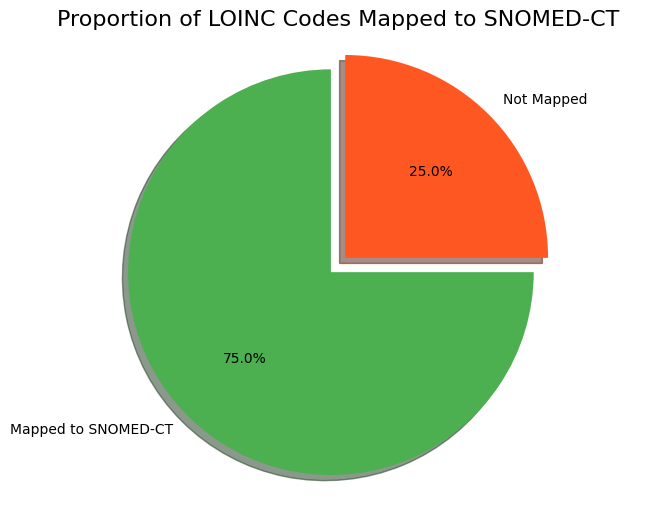

In [11]:
df_mapped = observations_mapped[['loinc', 'loinc_desc','snomed', 'snomed_desc']].drop_duplicates()

# Überprüfe, ob die Spalte 'snomed' in df_mapped vorhanden ist
if 'snomed' not in df_mapped.columns:
    raise KeyError("Die Spalte 'snomed' existiert nicht in df_mapped. Bitte überprüfe die Spaltennamen.")

# Zähle die Anzahl der gemappten und nicht gemappten Codes
mapped_count = df_mapped['snomed'].notna().sum()  # Gemappte Codes
total_count = len(df_mapped)  # Gesamtanzahl der Codes
unmapped_count = total_count - mapped_count  # Nicht gemappte Codes

# Daten für die Visualisierung
labels = ['Mapped to SNOMED-CT', 'Not Mapped']
sizes = [mapped_count, unmapped_count]
colors = ['#4CAF50', '#FF5722']  # Farben für die Segmente

# Kreisdiagramm erstellen
plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Prozentangaben anzeigen
    startangle=90,      # Startwinkel für das erste Segment
    colors=colors,      # Farben der Segmente
    shadow=True,        # Schatten für eine bessere Darstellung
    explode=(0.1, 0)    # Hervorheben des ersten Segments (optional)
)
plt.title('Proportion of LOINC Codes Mapped to SNOMED-CT', fontsize=16)
plt.axis('equal')  # Stellt sicher, dass das Kreisdiagramm ein Kreis ist
plt.show()

# **Prüfung Datenqualität**

## **Überprüfung des SNOMED-CT und ICD Format**



Codes aus ICD-10 haben folgendes Format:

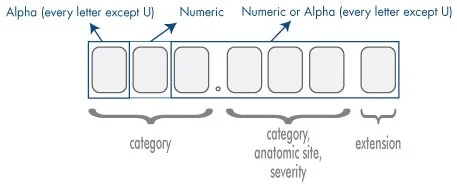

Regex:
^[A-Z]\d{2}(\.\w{1,4})?$

einzelner Buchstabe gefolgt von 2 Ziffern
optional . gefolgt von bis zu 4 Ziffern oder Buchstaben

In [12]:
# ICD-Validierung
regex_icd = r'^[A-Z]\d{2}(\.\w{1,4})?$'
conditions_mapped['icd'] = conditions_mapped['icd'].fillna('').astype(str)
conditions_mapped['invalid_icd'] = np.where(
    conditions_mapped['icd'].str.match(regex_icd),
    0,
    1
)

# SNOMED-Validierung
regex_snomed = r'^\d{6,}$'
conditions_mapped['snomed'] = conditions_mapped['snomed'].fillna('').astype(str)
conditions_mapped['invalid_snomed'] = np.where(
    conditions_mapped['snomed'].str.match(regex_snomed),
    0,
    1
)

# Anzahl der ungültigen Codes ermitteln
invalid_icd_count = conditions_mapped['invalid_icd'].sum()
invalid_snomed_count = conditions_mapped['invalid_snomed'].sum()

print("Zusammenfassung der Überprüfung:")
print(f"  Ungültige ICD-Codes: {invalid_icd_count}")
print(f"  Ungültige SNOMED-Codes: {invalid_snomed_count}")

# Zeige ein paar Beispielzeilen für ungültige ICD- bzw. SNOMED-Codes, falls vorhanden
if invalid_icd_count > 0:
    print("\nBeispielzeilen mit ungültigen ICD-Codes:")
    print(conditions_mapped.loc[conditions_mapped['invalid_icd'] == 1, ['icd', 'icd_desc']].head(10).to_string(index=False))
else:
    print("\nAlle ICD-Codes sind gültig.")

if invalid_snomed_count > 0:
    print("\nBeispielzeilen mit ungültigen SNOMED-Codes:")
    print(conditions_mapped.loc[conditions_mapped['invalid_snomed'] == 1, ['snomed', 'snomed_desc']].head(10).to_string(index=False))
else:
    print("\nAlle SNOMED-Codes sind gültig.")


Zusammenfassung der Überprüfung:
  Ungültige ICD-Codes: 0
  Ungültige SNOMED-Codes: 0

Alle ICD-Codes sind gültig.

Alle SNOMED-Codes sind gültig.


## **Liegt für alle gemapped ICD-Codes eine Beschreibung vor?**





In [13]:
# Falls keine Beschreibung vorliegt, wird in der Spalte 'invalid_desc' der Wert 1 gesetzt
conditions_mapped['invalid_desc'] = np.where(conditions_mapped['icd_desc'].isna(), 1, 0)

# Überprüfung, ob fehlende Beschreibungen vorliegen:
if conditions_mapped['invalid_desc'].sum() > 0:
    print("Es gibt Zeilen ohne Beschreibung:")
    print(conditions_mapped[conditions_mapped['invalid_desc'] == 1])
else:
    print("Alle Zeilen besitzen eine Beschreibung.")


Alle Zeilen besitzen eine Beschreibung.


## **Dupletten-Test SNOMED-CT und ICD-10 Mapping**

In [14]:
# Setze die Spalte 'duplicate' auf 1, wenn eine Zeile ein Duplikat ist, sonst auf 0
conditions_mapped['duplicate'] = np.where(conditions_mapped.duplicated(), 1, 0)

# Überprüfe, ob Duplikate vorhanden sind
if conditions_mapped['duplicate'].sum() > 0:
    print("Es wurden Dupletten gefunden:")
    print(conditions_mapped[conditions_mapped['duplicate'] == 1])
else:
    print("Keine Dupletten im Mapping vorliegend.")


Keine Dupletten im Mapping vorliegend.


## **Inkonsistenzprüfung des SNOMED-CT- und ICD-10-Mappingss**

In [15]:
# --- Schritt 1: Inkonsistente Mappings ermitteln ---
# Gruppierung nach SNOMED und Zählung der eindeutigen ICD-Codes pro SNOMED-Code
inconsistent = conditions_mapped.groupby('snomed')['icd'].nunique()

# Filter: Behalte nur SNOMED-Codes, die mehr als einen ICD-Code haben
inconsistent = inconsistent[inconsistent > 1]

# Ausgabe der inkonsistenten Mappings
if not inconsistent.empty:
    print("Inkonsistente Mappings für folgende SNOMED-Codes:")
    print(inconsistent)
else:
    print("Keine inkonsistenten Mappings gefunden.")

# --- Schritt 2: Markierung der inkonsistenten Zeilen ---
# Erstelle eine Liste der inkonsistenten SNOMED-Codes
inconsistent_snomed_codes = inconsistent.index.tolist()

# Füge eine Spalte 'inconsistent' hinzu, die angibt, ob der jeweilige SNOMED-Code inkonsistent ist
conditions_mapped['inconsistent'] = conditions_mapped['snomed'].isin(inconsistent_snomed_codes)


Keine inkonsistenten Mappings gefunden.


## **Fazit SNOMED-CT und ICD-10 Mapping**

In [16]:

# Erweiterte Qualitätszählung
# Hier werden Zeilen gezählt, bei denen mindestens eines der Qualitätsprobleme vorliegt:

count = (
    (conditions_mapped["invalid_icd"] == 1) |
    (conditions_mapped["invalid_desc"] == 1) |
    (conditions_mapped["duplicate"] == 1) |
    (conditions_mapped["inconsistent"] == True)
).sum()

print(f"{count} Zeilen der Tabelle conditions weisen nach dem Mapping eine unzureichende Datenqualität auf.")


0 Zeilen der Tabelle conditions weisen nach dem Mapping eine unzureichende Datenqualität auf.


## **Datenvalidierung SNOMED-CT auf ICD-10**

In [17]:
# willkürliche Auswahl von 20 Patienten zur Datenvalidierung
pat_ids = conditions_mapped['patient'].sample(n=20, random_state=42)
pat_ids.head(20)

,patient
1912,5e93a0c0-10e2-7e61-ffee-73e3554f7845
5272,3845c8f4-39c6-eeec-75e6-2780169f0aa3
5230,fb59b309-617e-85ca-6862-3bbe8f64d2fe
4231,714271d3-377b-7eb0-6d14-97d4fde60cf5
5890,5dc018ef-17fe-e5eb-6d82-7390b8b7dd91
233,201158d6-9487-bb13-821a-5b9884d30785
2576,87254a1d-f721-ab3f-7134-93c1f29ea0ff
296,c0c19eb3-0366-fd10-0e52-792611c848f3
4882,ae7a6eb4-abbd-f1b2-7f76-ac75c36471f4
2915,4a7748c9-ad39-38cd-451f-a4485eec931a


In [18]:
conditions_sample = conditions_mapped[conditions_mapped['patient'].isin(pat_ids)]
conditions_sample

,start,stop,patient,encounter,snomed,snomed_desc,icd,icd_desc,invalid_icd,invalid_snomed,invalid_desc,duplicate,inconsistent
92,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,49727002,Cough (finding),R05,Cough,0,0,0,0,False
93,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False
94,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,56018004,Wheezing (finding),R06.2,Wheezing,0,0,0,0,False
95,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,386661006,Fever (finding),R50.9,"Fever, unspecified",0,0,0,0,False
96,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,36955009,Loss of taste (finding),R43.1,Ageusia,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,2020-03-01,2020-04-03,50a6d2a0-f8f0-4dd1-4c61-2e5d7083bf80,c3e33d76-8980-bf71-f176-7b2729ed318f,57676002,Joint pain (finding),M25.50,Pain in unspecified joint,0,0,0,0,False
6102,2020-03-01,2020-04-03,50a6d2a0-f8f0-4dd1-4c61-2e5d7083bf80,c3e33d76-8980-bf71-f176-7b2729ed318f,386661006,Fever (finding),R50.9,"Fever, unspecified",0,0,0,0,False
6103,2020-03-01,2020-04-03,50a6d2a0-f8f0-4dd1-4c61-2e5d7083bf80,c3e33d76-8980-bf71-f176-7b2729ed318f,36955009,Loss of taste (finding),R43.1,Ageusia,0,0,0,0,False
6104,2020-03-01,2020-03-01,50a6d2a0-f8f0-4dd1-4c61-2e5d7083bf80,c3e33d76-8980-bf71-f176-7b2729ed318f,840544004,Suspected COVID-19,U07.2,"COVID-19, virus not identified",0,0,0,0,False


In [19]:
# Überprüfung, ob ICD-Code tatsächlich in der ICD-Klasssifikation enthalten ist

# ICD-Klassifikation
# nur terminale Codes enthalten
icd = pd.read_csv("/content/drive/MyDrive/Gruppe A/ICD/codes.csv", header = None)
icd = icd[[2,4]]
icd = icd.rename(columns = {2:"icd", 4:"icd_desc"})

# Punkt fehlt in Tabellle
icd['icd'] = icd['icd'].apply(lambda x: x if len(x) <= 3 else x[:3] + '.' + x[3:])
icd = icd.drop_duplicates()

# Covid-Code fehlt in Datei
new_row1 = pd.DataFrame([{"icd": "U07.1", "icd_desc": "COVID-19"}])
icd = pd.concat([icd, new_row1], ignore_index=True)
new_row2 = pd.DataFrame([{"icd": "U07.2", "icd_desc": "COVID-19, virus not identified"}])
icd = pd.concat([icd, new_row2], ignore_index=True)

icd.head(5)

,icd,icd_desc
0,A00.0,"Cholera due to Vibrio cholerae 01, biovar chol..."
1,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,A00.9,"Cholera, unspecified"
3,A01.00,"Typhoid fever, unspecified"
4,A01.01,Typhoid meningitis


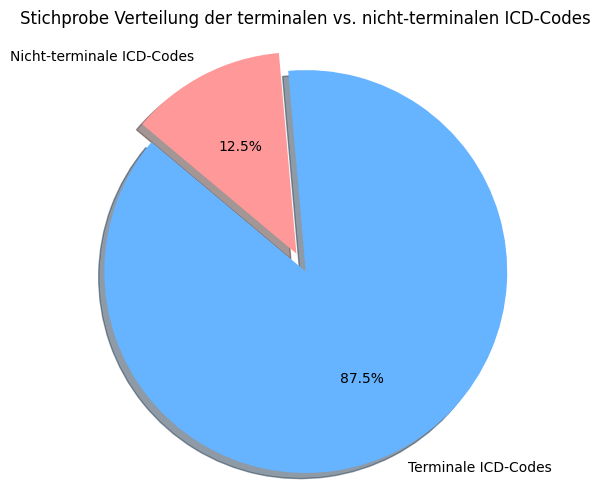

Stichprobenhafte Überprüfung:
28 von 32 SNOMED CT Codes konnten einem endstelligen ICD-Code zugeordnet werden


In [20]:
# Erstelle eine explizite Kopie des DataFrames, um einen View zu vermeiden
conditions_sample = conditions_sample.copy()

# Setze die Spalte 'terminal_icd' – 1, wenn der ICD-Code in icd['icd'] vorhanden ist, sonst 0
conditions_sample.loc[:, 'terminal_icd'] = conditions_sample['icd'].isin(icd['icd']).astype(int)

# Terminale ICD-Codes berechnen:
# Hier gehen wir davon aus, dass terminal_icd == 0 einen terminalen ICD-Code darstellt
# Korrektur 9.2.25: terminal_icd==1 stellt terminale ICD-Codes dar  & Anzahl SNOMED codes mit terminalem ICD-Code
#count_terminal = conditions_sample[conditions_sample['terminal_icd'] == 0]['icd'].nunique()
count_terminal = conditions_sample[conditions_sample['terminal_icd'] == 1]['snomed'].nunique()


# Gesamtanzahl der eindeutigen ICD-Codes:
#count_total = conditions_sample['icd'].nunique()
# Korrektur Anzahl SNOMED codes
count_total = conditions_sample['snomed'].nunique()

# Anzahl der SNOMED codes mit nicht-terminalem ICD-Code:
count_non_terminal = conditions_sample[conditions_sample['terminal_icd'] == 0]['snomed'].nunique()

# Erstelle ein Pie Chart, um die Verteilung darzustellen:
labels = ['Terminale ICD-Codes', 'Nicht-terminale ICD-Codes']
sizes = [count_terminal, count_non_terminal]
colors = ['#66b3ff', '#ff9999']  # Beispielhafte Farben
explode = (0.1, 0)  # Hebt das Segment der terminalen ICD-Codes hervor

plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Stichprobe Verteilung der terminalen vs. nicht-terminalen ICD-Codes")
plt.axis('equal')  # Stellt sicher, dass das Pie Chart rund ist
plt.show()

print(f"Stichprobenhafte Überprüfung:\n{count_terminal} von {count_total} SNOMED CT Codes konnten einem endstelligen ICD-Code zugeordnet werden")


In [21]:
conditions_sample[conditions_sample['terminal_icd'] == 0]

,start,stop,patient,encounter,snomed,snomed_desc,icd,icd_desc,invalid_icd,invalid_snomed,invalid_desc,duplicate,inconsistent,terminal_icd
93,2020-03-07,2020-04-03,bd4c46f4-f960-9215-dbc1-3a19c72c4c32,b1b9429e-883c-7208-caad-527726a02d6b,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False,0
290,2020-03-06,2020-03-15,c0c19eb3-0366-fd10-0e52-792611c848f3,4e52ff98-5028-14dd-97bc-a2298b4c3ff3,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False,0
299,2020-03-06,2020-03-15,c0c19eb3-0366-fd10-0e52-792611c848f3,c9a2cc1f-adc0-bd7f-2d00-67eafe6597e2,65710008,Acute respiratory failure (disorder),J96.0,Acute respiratory failure,0,0,0,0,False,0
535,2020-03-06,2020-03-17,b23449b6-4ae4-712c-2363-762a68b01d67,6ab8ca40-5bf3-171c-482e-7c7bdb42dd77,65710008,Acute respiratory failure (disorder),J96.0,Acute respiratory failure,0,0,0,0,False,0
1664,2020-02-16,2020-03-12,deeabe0a-7cc8-6835-f529-0695b8c1ddd5,a22c1400-35e0-213d-90fe-fd3c7e4a59ab,249497008,Vomiting symptom (finding),R11,Nausea and vomiting,0,0,0,0,False,0
2126,2020-03-05,2020-03-31,f22b4de5-9ea2-591b-19cb-bcf39efaa63d,72089b86-8ee0-6611-8328-a0a93a8e1863,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False,0
2129,2020-03-05,2020-03-31,f22b4de5-9ea2-591b-19cb-bcf39efaa63d,72089b86-8ee0-6611-8328-a0a93a8e1863,249497008,Vomiting symptom (finding),R11,Nausea and vomiting,0,0,0,0,False,0
4883,2020-02-23,2020-03-17,ae7a6eb4-abbd-f1b2-7f76-ac75c36471f4,d78f85ae-f230-073a-b083-9598fb01caef,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False,0
5022,2020-03-15,2020-04-02,713cd60b-58ea-d553-e3ac-ba33f9ea7b39,2574bfc3-3935-3524-184b-426bbf633dc7,65710008,Acute respiratory failure (disorder),J96.0,Acute respiratory failure,0,0,0,0,False,0
5227,2020-03-06,2020-04-02,fb59b309-617e-85ca-6862-3bbe8f64d2fe,b3c65b1d-ef3c-efb0-4d29-b69861207ab8,267036007,Dyspnea (finding),R06.0,Dyspnea,0,0,0,0,False,0


## **Überprüfung LOINC Format**


Ungültige LOINC-Codes: 32421
Gültige LOINC-Codes: 87516


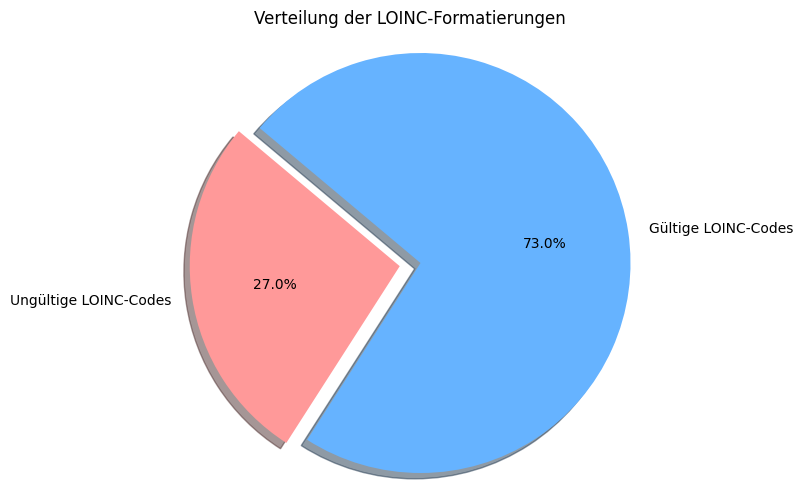


Gruppierung der Fehlerursachen für ungültige LOINC-Codes:
                           invalid_reason  count
Kein Bindestrich und nicht rein numerisch  32421

Beispielhafte ungültige LOINC-Codes:
loinc                            invalid_reason
 QALY Kein Bindestrich und nicht rein numerisch
 QOLS Kein Bindestrich und nicht rein numerisch
 QOLS Kein Bindestrich und nicht rein numerisch
 QOLS Kein Bindestrich und nicht rein numerisch
 DALY Kein Bindestrich und nicht rein numerisch
 QALY Kein Bindestrich und nicht rein numerisch
 DALY Kein Bindestrich und nicht rein numerisch
 QOLS Kein Bindestrich und nicht rein numerisch
 DALY Kein Bindestrich und nicht rein numerisch
 QALY Kein Bindestrich und nicht rein numerisch


In [22]:
# 1. Datenbankabfrage und Vorbereitung der Tabelle
query = "SELECT * FROM observations"
observations = pd.read_sql_query(query, conn)

observations = (
    observations
    .rename(columns=lambda x: x.lower())
    .rename(columns={'code': 'loinc', 'description': 'loinc_desc'})
    .dropna(subset=["loinc"])
)

# 2. Merge: observations mit map_loinc zusammenführen
observations = observations.merge(map_loinc, how="left", on=["loinc", "loinc_desc"])

# 3. LOINC-Validierung
regex_with_hyphen = r"^\d{3,5}-\d$"  # z.B. "789-8"
regex_no_hyphen = r"^\d{6}$"          # z.B. "123456"
observations['valid_loinc'] = (
    observations['loinc'].str.match(regex_with_hyphen) |
    observations['loinc'].str.match(regex_no_hyphen)
)

# Zählung der gültigen und ungültigen Codes
valid_count = observations['valid_loinc'].sum()
invalid_count = (~observations['valid_loinc']).sum()

print(f"\nUngültige LOINC-Codes: {invalid_count}")
print(f"Gültige LOINC-Codes: {valid_count}")

# 3a. Visualisierung: Pie Chart
labels = ['Ungültige LOINC-Codes', 'Gültige LOINC-Codes']
sizes = [invalid_count, valid_count]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        explode=(0.1, 0), shadow=True, startangle=140)
plt.title("Verteilung der LOINC-Formatierungen")
plt.axis('equal')
plt.show()

# 4. Gruppierung der Fehlerursachen bei ungültigen LOINC-Codes
def get_invalid_reason(code):
    """
    Bestimmt den Fehlergrund für einen ungültigen LOINC-Code.
    Erwartete Formate:
      - Mit Bindestrich: 3-5 Ziffern, Bindestrich, 1 Ziffer (z.B. "789-8")
      - Ohne Bindestrich: 6 Ziffern (z.B. "123456")
    """
    if '-' in code:
        parts = code.split('-')
        if len(parts) != 2:
            return "Mehr als ein Bindestrich"
        left, right = parts
        if not (left.isdigit() and right.isdigit()):
            return "Nicht-numerische Zeichen"
        if len(right) != 1:
            return f"Nach Bindestrich {len(right)} Ziffer(n) statt 1"
        if len(left) not in [3, 4, 5]:
            return f"Vor Bindestrich {len(left)} Ziffer(n) statt 3-5"
    else:
        if code.isdigit():
            if len(code) != 6:
                return f"Erwartet 6 Ziffern, gefunden {len(code)}"
            return "Unbekannter Fehler (6 Ziffern ohne Bindestrich)"
        return "Kein Bindestrich und nicht rein numerisch"
    return "Unbekannter Fehler"

# Erstelle DataFrame der ungültigen Codes und bestimme Fehlerursachen
invalid_df = observations.loc[~observations['valid_loinc']].copy()
invalid_df['invalid_reason'] = invalid_df['loinc'].apply(get_invalid_reason)

# Gruppierung der Fehlerursachen
grouped_reasons = (
    invalid_df.groupby('invalid_reason')
              .size()
              .reset_index(name='count')
)

print("\nGruppierung der Fehlerursachen für ungültige LOINC-Codes:")
print(grouped_reasons.to_string(index=False))

# 5. Ausgabe von 10 ungültigen LOINC-Codes (bzw. weniger, falls nicht genügend vorhanden)
sample_invalid = invalid_df.sample(n=min(10, len(invalid_df)), random_state=42)
print("\nBeispielhafte ungültige LOINC-Codes:")
print(sample_invalid[['loinc', 'invalid_reason']].to_string(index=False))


## **Hat jeder LOINC einen Laborwert**

In [23]:
# Sicherstellen, dass die Spalte 'value' existiert
if 'value' not in observations_mapped.columns:
    raise KeyError("Die Spalte 'value' wurde in den Daten nicht gefunden.")

# Filter: Zeilen, in denen der 'value' leer oder NaN ist.
# Leere Strings werden nach Entfernen von Leerzeichen als fehlend gewertet.
missing_value_mask = (
    observations_mapped['value'].isnull() | (observations_mapped['value'].astype(str).str.strip() == "")
)
rows_missing_value = observations_mapped[missing_value_mask]

# Ausgabe der Ergebnisse
if not rows_missing_value.empty:
    print("Die folgenden Datensätze besitzen keinen Wert in der Spalte 'value':")
    print(rows_missing_value)
else:
    print("Alle Datensätze besitzen einen Wert in der Spalte 'value'.")


Alle Datensätze besitzen einen Wert in der Spalte 'value'.


## **Dubletten-Test SNOMED-CT und LOINC**


Zusammenfassung der Dubletten (basierend auf Patient, Encounter, LOINC, Value und Date):
Gesamte doppelte Zeilen: 10
Einzigartige Patienten: 5


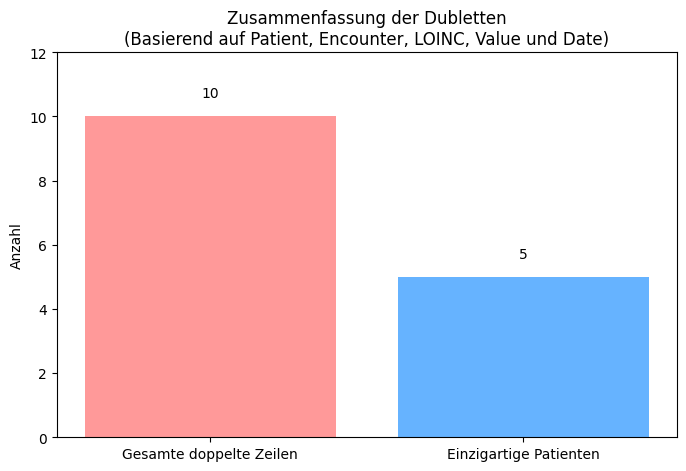


Beispielhafte Dubletten (je Gruppe alle zugehörigen Datensätze):

--------------------------------------------------------------------------------
Gruppe: Patient: 4b721e68-5c2d-7699-72fe-8000688bcef6, Encounter: e81b5c76-58bc-a817-9662-fe199662263a, LOINC: 2708-6, Value: 83.4, Date: 2020-03-11T21:44:20Z (Anzahl: 2)
                date                              patient                            encounter  loinc                          loinc_desc value units    type    snomed                   snomed_desc
2020-03-11T21:44:20Z 4b721e68-5c2d-7699-72fe-8000688bcef6 e81b5c76-58bc-a817-9662-fe199662263a 2708-6 Oxygen saturation in Arterial blood  83.4     % numeric 103228002 Oxygen saturation measurement
2020-03-11T21:44:20Z 4b721e68-5c2d-7699-72fe-8000688bcef6 e81b5c76-58bc-a817-9662-fe199662263a 2708-6 Oxygen saturation in Arterial blood  83.4     % numeric 103228002 Oxygen saturation measurement


--------------------------------------------------------------------------------
Grup

In [24]:
# Überprüfung auf Dubletten:
# Eine Dublette liegt vor, wenn in den Spalten "patient", "encounter", "loinc", "value" und "date" alle Werte identisch sind.
required_columns = ['patient', 'encounter', 'loinc', 'value', 'date']
missing_columns = [col for col in required_columns if col not in observations_mapped.columns]

if missing_columns:
    print(f"\nDie folgenden erforderlichen Spalten fehlen: {', '.join(missing_columns)}")
    total_duplicate_rows = 0
    unique_duplicate_groups = 0
else:
    duplicate_groups = (
        observations_mapped.groupby(required_columns)
        .size()
        .reset_index(name='count')
    )

    # Behalte nur Gruppen, die mehr als einmal vorkommen (also Dubletten)
    duplicate_groups = duplicate_groups[duplicate_groups['count'] > 1]

    total_duplicate_rows = duplicate_groups['count'].sum()
    unique_duplicate_groups = duplicate_groups.shape[0]

    print("\nZusammenfassung der Dubletten (basierend auf Patient, Encounter, LOINC, Value und Date):")
    print(f"Gesamte doppelte Zeilen: {total_duplicate_rows}")
    print(f"Einzigartige Patienten: {unique_duplicate_groups}")

    # 5. Grafische Darstellung der Dubletten-Zusammenfassung
    labels = ['Gesamte doppelte Zeilen', 'Einzigartige Patienten']
    values = [total_duplicate_rows, unique_duplicate_groups]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=['#ff9999', '#66b3ff'])

    # Werte oberhalb der Balken anzeigen
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.title("Zusammenfassung der Dubletten\n(Basierend auf Patient, Encounter, LOINC, Value und Date)")
    plt.ylabel("Anzahl")
    plt.ylim(0, max(values) * 1.2)
    plt.show()

    # 6. Auswahl: 10 Beispiel-Dubletten (verschiedene Kombinationen)
    n = min(10, duplicate_groups.shape[0])
    sample_dup_groups = duplicate_groups.sample(n=n, random_state=42)

    # Für jede ausgewählte Gruppe: Alle zugehörigen Datensätze anzeigen
    print("\nBeispielhafte Dubletten (je Gruppe alle zugehörigen Datensätze):\n")
    for idx, group in sample_dup_groups.iterrows():
        mask = (
            (observations_mapped['patient'] == group['patient']) &
            (observations_mapped['encounter'] == group['encounter']) &
            (observations_mapped['loinc'] == group['loinc']) &
            (observations_mapped['value'] == group['value']) &
            (observations_mapped['date'] == group['date'])
        )
        group_data = observations_mapped[mask]
        print("-" * 80)
        print(f"Gruppe: Patient: {group['patient']}, Encounter: {group['encounter']}, "
              f"LOINC: {group['loinc']}, Value: {group['value']}, Date: {group['date']} (Anzahl: {group['count']})")
        print(group_data.to_string(index=False))
        print("\n")


## **Inkonsistenzprüfung des SNOMED-CT- und LOINC-Mappings**


In [25]:
# Schritt 1: Inkonsistente Mappings ermitteln
# Gruppierung nach LOINC und Zählung der eindeutigen SNOMED-Codes pro LOINC-Code
inconsistent = observations_mapped.groupby('loinc')['snomed'].nunique()

# Filter: Behalte nur LOINC-Codes, die mehr als einen SNOMED-Code haben
inconsistent = inconsistent[inconsistent > 1]

# Ausgabe der inkonsistenten Mappings
if not inconsistent.empty:
    print("Inkonsistente Mappings für folgende LOINC-Codes:")
    print(inconsistent)
else:
    print("Keine inkonsistenten Mappings gefunden.")

# Schritt 2: Markierung der inkonsistenten Zeilen
# Erstelle eine Liste der inkonsistenten LOINC-Codes
inconsistent_loinc_codes = inconsistent.index.tolist()

# Füge eine Spalte 'inconsistent' hinzu, die angibt, ob der jeweilige LOINC-Code inkonsistent ist
observations_mapped['inconsistent'] = observations_mapped['loinc'].isin(inconsistent_loinc_codes)


Keine inkonsistenten Mappings gefunden.


In [26]:
# Verbindung zur Datenbank lösen
conn.close()